# 국민청원 데이터로 청원 카테고리 분류하기
### 기존 분류에 기타 카테고리를 다른 카테고리로 예측하는 코드 추가
### XGBoost로 예측 추가
* 청와대 국민청원 : https://www1.president.go.kr/petitions
* 학습세트의 카테고리를 바탕으로 테스트 세트의 청원 카테고리를 분류해 봅니다.
* `기타`로 설정된 카테고리를 텍스트 데이터로 예측해서 보정해 주고 다시 카테고리를 예측해 봅니다.

1. 데이터 전처리
1. 기타 청원과 아닌 것 나누기
    1. 단어 벡터화(BOW, TF-IDF)
    1. 기타 청원 분류하기(RF)
1. 예측값을 category_pred 컬럼에 넣어주기
1. 학습세트와 테스트세트를 7:3으로 임의로 나누기
1. 분류기 설정하기(RF, XGB)
1. 분류기로 학습시키기(RF, XGB)
1. label 데이터를 예측한 category_pred 를 사용하기
1. 학습의 정확도 보기(RF, XGB)
1. 테스트 데이터 예측하기(RF, XGB)
1. 실제 데이터와 예측결과의 차이를 보기(RF, XGB)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import re
print(pd.__version__)
print(np.__version__)

0.21.0
1.14.0


# 데이터 로드하기

In [3]:
# 크롤링해 온 국민청원 데이터를 판다스를 통해 읽어옵니다.
petitions = pd.read_csv('data/petition.csv', parse_dates=['start', 'end'])
# 데이터의 크기가 어느정도인지 봅니다.
petitions.shape

(192387, 8)

In [4]:
petitions.describe()

,article_id,answered,votes
count,192387.000000,192387.000000,192387.000000
mean,113937.905035,0.000135,145.026748
std,70999.561497,0.011624,4382.942031
min,21.000000,0.000000,0.000000
25%,49908.500000,0.000000,1.000000
50%,111144.000000,0.000000,3.000000
75%,173456.500000,0.000000,10.000000
max,242902.000000,1.000000,615354.000000


In [5]:
# 전체 데이터 중 투표가 1000건 이상인 데이터를 기준으로 가져옵니다. 아웃라이어 데이터 제거를 위해 10만건 이상 데이터도 제거합니다.
df = petitions.loc[(petitions['votes'] > 1000)].copy()
df.shape

(1687, 8)

In [6]:
df.describe()

,article_id,answered,votes
count,1687.000000,1687.000000,1687.000000
mean,129882.737404,0.015412,14519.085359
std,71267.473739,0.123221,44530.991294
min,28.000000,0.000000,1002.000000
25%,65556.500000,0.000000,1585.500000
50%,139835.000000,0.000000,2862.000000
75%,188582.500000,0.000000,7637.500000
max,242889.000000,1.000000,615354.000000


In [7]:
category_count = df['category'].value_counts()
category_count

인권/성평등         217
보건복지           181
육아/교육          173
안전/환경          157
정치개혁           156
문화/예술/체육/언론    132
기타             130
교통/건축/국토       123
행정              78
일자리             77
외교/통일/국방        69
반려동물            63
경제민주화           62
미래              27
성장동력            18
저출산/고령화대책       13
농산어촌            11
Name: category, dtype: int64

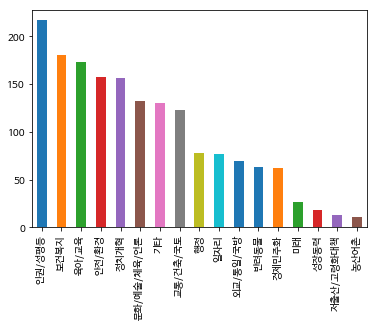

In [8]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = 'NanumBarunGothic'
category_count.plot(kind='bar')

In [9]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
df['category_pred'] = df['category'].copy()

In [10]:
df.head()

,article_id,start,end,answered,votes,category,title,content,category_pred
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,경제민주화
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,일자리
38,61,2017-08-19,2017-08-26,0,1185,일자리,영어회화전문강사제도는 유지되어야합니다.,1. 영전강의고용안정을 원합니다\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니...,일자리


In [11]:
# 첫 번째 인덱스를 가져와 봅니다.
sample_index = 7
sample_index

7

In [12]:
sample_title = df['title'][sample_index]
sample_title

'소액주주를 보호해주십시오'

In [13]:
sample_content = petitions['content'][sample_index]
sample_content

'**  존경하옵는 문재인대통령님께\\n저는 중국원양자원이라는 KOSPI상장사의 소액 주주입니다. 중국원양자원(이하 중원)은 이번 재회계감사에서 의견거절이라는 감사인 판단이 내려져 꿈에도 생각못한 상장폐지를 목전에 두고 있습니다.\\n상장폐지가되면 국내에 상장하여 천문학적인 금액을 취득하여 회사의 규모를 키우고 개인자산을 불린 후 자신의 지분도  다 팔아서 이득을 챙긴 중국인 장화리 사장은 정리매매때 휴지조각의 비용으로 자신의 지분을 다시 사들이고 대주주로서의 지위를 다시 획득하여 온전히 자신의 기업으로 만들수 있습니다.\\n결국 한국 국민들의 피땀어린 투자금으로 중국인 사장의 부를 채워주지만 이에 대해 한국의 금융당국 및 상장과 운영의 주체인 거래소는 누구도 이에대한 책임없이 이를 그냥 덮어버리고만 말것입니다.\\n이로인해 약 2만 5천의 국내소액주주는 피눈물을 흘리며 고통속에 살게 될 것입니다.\\n주식투자는 개인의 판단하에 이루어지는 것이나 투자에 대한 개인의 책임을 묻기전에 그 과정은 규정과 상식에 맞게 공정하고 정의로워야 할 것입니다. 이는 존경하는 문대통령님의 말씀이라 가슴깊이 새기고 있었으나 현재 우리나라의 금융 시스템, 특히 거래소와 회계감사는 그렇지 못한 것 같습니다.\\n이렇게 생각하게된 이유는 이번 회계감사의 주된 의견거절의 이유 때문입니다\\n이번 신한회계법인의 추측적이고 터무니없는 의견거절로 전재산이 한순간에 물거품으로 사라질 위기에 처한 본인을 비롯한 많은 사람들이 죽음이라는 극단적인 선택앞에 내몰려져 억울함과 원통함에 피눈물을 흘리고 있습니다. .\\n기업의 사업성이나 계속 존속여부를 점검하는 감사자인 회계법인은 오직 밝혀진 사실과 그에 따른 증거만을 근거로 공정하게 기업의 존속여부에 대한 의견을 내야하고 유추할 경우에도 당연히 관련 법이나 판례에 근거하여야 합니다.\\n그러나 신한회계법인은 법또는 제도권으로 확정되지 않은 추정사항을 의견거절의\'결정적 이유\'로 명시하였는바 이는 감사자의 \'의견거절\'에 따른 참혹한 결과로 볼때 

# 전처리 하기 

In [14]:
def preprocessing(text):
    # 개행문자 제거
    text= str(text)
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [15]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['수', '그', '있는', '있습니다','년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [16]:
# 샘플데이터에 적용
pre_sample_content = preprocessing(sample_content)

In [17]:
pre_sample_content = remove_stopwords(pre_sample_content)

In [18]:
pre_sample_content

'    존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니다  중국원양자원 이하 중원 은 이번 재회계감사에서 의견거절이라는 감사인 판단이 내려져 꿈에도 생각못한 상장폐지를 목전에 두고  상장폐지가되면 국내에 상장하여 천문학적인 금액을 취득하여 회사의 규모를 키우고 개인자산을 불린 후 자신의 지분도  다 팔아서 이득을 챙긴 중국인 장화리 사장은 정리매매때 휴지조각의 비용으로 자신의 지분을 다시 사들이고 대주주로서의 지위를 다시 획득하여 온전히 자신의 기업으로 만들수  결국 한국 국민들의 피땀어린 투자금으로 중국인 사장의 부를 채워주지만 이에 대해 한국의 금융당국 상장과 운영의 주체인 거래소는 누구도 이에대한 책임없이 이를 그냥 덮어버리고만 말것입니다  이로인해 약  만  천의 국내소액주주는 피눈물을 흘리며 고통속에 살게 될 것입니다  주식투자는 개인의 판단하에 이루어지는 것이나 투자에 개인의 책임을 묻기전에 과정은 규정과 상식에 맞게 공정하고 정의로워야 것입니다  이는 존경하는 문대통령님의 말씀이라 가슴깊이 새기고 있었으나 현재 우리나라의 금융 시스템  특히 거래소와 회계감사는 그렇지 못한 것  이렇게 생각하게된 이유는 이번 회계감사의 주된 의견거절의 이유 때문입니다 이번 신한회계법인의 추측적이고 터무니없는 의견거절로 전재산이 한순간에 물거품으로 사라질 위기에 처한 본인을 비롯한 사람들이 죽음이라는 극단적인 선택앞에 내몰려져 억울함과 원통함에 피눈물을 흘리고    기업의 사업성이나 계속 존속여부를 점검하는 감사자인 회계법인은 오직 밝혀진 사실과 그에 따른 증거만을 근거로 공정하게 기업의 존속여부에 의견을 내야하고 유추할 경우에도 당연히 관련 법이나 판례에 근거하여야  그러나 신한회계법인은 법또는 제도권으로 확정되지 않은 추정사항을 의견거절의 결정적 이유 로 명시하였는바 이는 감사자의  의견거절 에 따른 참혹한 결과로 볼때      명의 국민들과 가족들은 공정한 감사결과라 절대로 인정할수  고통의 원인은 법 제도나 규정에 근거를 두지 않

In [19]:
%time df['content_preprocessing'] = df['content'].apply(preprocessing)

CPU times: user 179 ms, sys: 4.07 ms, total: 183 ms
Wall time: 185 ms


In [20]:
%time df['content_preprocessing2'] = df['content_preprocessing'].apply(remove_stopwords)

CPU times: user 318 ms, sys: 4.63 ms, total: 322 ms
Wall time: 323 ms


# 기계학습으로 기타 제거하기
* 기타로 분류된 청원중에 특정 카테고리로 분류해 주면 좀 더 정확도가 높아질 것이라는 가설을 세워봅니다.
* 따라서 기타로 분류된 청원을 다른 청원을 바탕으로 학습시켜 분류해 봅니다.

In [21]:
df['category_pred'] = df['category'].copy()

In [22]:
df_not_etc = df.loc[df['category'] != '기타'].copy()
df_etc = df.loc[df['category'] == '기타'].copy()
print(df_not_etc.shape)
print(df_etc.shape)

(1557, 11)
(130, 11)


## 기타 청원 분류하기 벡터화
* tfidf 를 사용해 벡터화 

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
stops = ['and', 'article', 'html', '수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = stops, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 9), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(1, 9), preprocessor=None,
        stop_words=['and', 'article', 'html', '수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜', '같은', '같습니다', '없습니다', '위해', '한다'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [25]:
%%time 
df_not_etc_vector = vectorizer.fit_transform(df_not_etc['content_preprocessing2'])
df_not_etc_vector.shape

CPU times: user 13.8 s, sys: 805 ms, total: 14.6 s
Wall time: 14.7 s


In [26]:
%%time 
df_etc_vector = vectorizer.fit_transform(df_etc['content_preprocessing2'])
df_etc_vector.shape

CPU times: user 1.39 s, sys: 78.7 ms, total: 1.47 s
Wall time: 1.47 s


In [27]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [28]:
%%time 
df_not_etc_tfidf = transformer.fit_transform(df_not_etc_vector)
df_not_etc_tfidf.shape

CPU times: user 5.93 ms, sys: 2.85 ms, total: 8.78 ms
Wall time: 6.9 ms


In [29]:
%%time 
df_etc_tfidf = transformer.fit_transform(df_etc_vector)
df_etc_tfidf.shape

CPU times: user 2.34 ms, sys: 1.65 ms, total: 3.99 ms
Wall time: 2.34 ms


## 기타 청원 분류하기

In [30]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [31]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
y_label = df_not_etc['category']
%time forest = forest.fit(df_not_etc_tfidf, y_label)

CPU times: user 2.16 s, sys: 51.9 ms, total: 2.21 s
Wall time: 719 ms


In [32]:
# 테스트 데이터를 넣고 예측합니다.
y_pred = forest.predict(df_etc_tfidf)
y_pred[:3]

array(['반려동물', '정치개혁', '안전/환경'], dtype=object)

In [33]:
df_etc['category_pred'] = y_pred
df_etc['category_pred'].value_counts()

육아/교육          23
인권/성평등         22
안전/환경          21
보건복지           18
경제민주화          12
정치개혁           10
반려동물            8
교통/건축/국토        5
외교/통일/국방        4
일자리             4
문화/예술/체육/언론     3
Name: category_pred, dtype: int64

## 기타 청원 분류 결과의 일부를 미리보기

In [34]:
df_etc[['votes', 'title', 'content', 'category', 'category_pred']].head(10)

,votes,title,content,category,category_pred
345,1126,문재인 대통령 기념 시계도 판매하라.,문재인 대통령 싸인이 들어간 기념 시계를 판매용으로 전환하여 주세요. SNS상의 국...,기타,반려동물
487,2749,2017년 10월 원천세 신고기한 및 9월분 전자세금계산서 발행기한일을 10월 13...,2017년 추석연휴 및 10월 2일 임시공휴일 지정이 확정됨에 따라 10월 초에 법...,기타,정치개혁
12747,1841,억울한죽음으로 돌아가신 고 이길연집배원의 순직을요구합니다,9월5일 서광주우체국에 근속중이신 고 이길연집배원 저희아버지가 자택에서 홀로목숨을끈...,기타,안전/환경
15456,1705,화훼도매시장 출입에 대한 출입증 발급을 청원합니다,화훼쪽에 종사하고 있는 사람입니다\n김영란법이 터지고 나서 뉴스를 보면 양재화훼시장...,기타,육아/교육
17150,1078,TNS홀딩스 강태욱 대표 사기 횡령 사건 해결을 부탁드립니다.,안녕하세요\n영등포구에 거주하는 30살 직장인입니다.\n2014년부터 알고지낸 재무...,기타,안전/환경
19072,123530,'일간베스트'사이트를 폐지해주세요,"국민들을 불편하게하고, 주변에 민폐를 끼치기로 유명한 일베는 사회적이슈로도 자주 떠...",기타,외교/통일/국방
22162,2452,경찰들의 성교육 이수 및 가중처벌,최근 경찰의 성폭행 성추행 성희롱등 그 주체가 범죄를 다루고 있는 경찰이된 사건들이...,기타,정치개혁
22375,2684,튜닝카 법 개정,차량튜닝에대한 법 개정이 필요할것같습니다. 요즘 튜닝사업이 확대되는 시대 입니다. ...,기타,안전/환경
22551,2278,을지대학교병원지부 노동조합 파업사태 해결 촉구,"문재인 대통령께\n안녕하세요 대통령님, 저는 대전 을지대학교병원에 근무하는 병원노동...",기타,인권/성평등
23292,1470,우리나라 법은 도대체 누구를 위한 법입니까 법 개선과 피해자를 위한 제도마련이 필요...,안녕하세요 .\n오늘도 국민들을 위해 나라에 힘써주시느라 너무나 고생이 많으십니다....,기타,보건복지


## 기타 카테고리로 분류한 데이터를 다시 합쳐 줍니다. 

In [35]:
df2 = pd.concat([df_not_etc, df_etc])
df2.shape

(1687, 11)

In [36]:
df2['category_pred'].value_counts()

인권/성평등         239
보건복지           199
육아/교육          196
안전/환경          178
정치개혁           166
문화/예술/체육/언론    135
교통/건축/국토       128
일자리             81
행정              78
경제민주화           74
외교/통일/국방        73
반려동물            71
미래              27
성장동력            18
저출산/고령화대책       13
농산어촌            11
Name: category_pred, dtype: int64

# 학습세트와 테스트세트 만들기
* 학습세트와 테스트세트를 7:3의 비율로 나눠 줍니다.

In [37]:
df2 = df2.reindex()

In [38]:
df2.shape

(1687, 11)

In [39]:
split_count = int(df2.shape[0] * 0.7)
split_count

1180

In [40]:
df_train = df2[:split_count].copy()
df_train.shape

(1180, 11)

In [41]:
df_train.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,경제민주화,존경하옵는 문재인대통령님께 저는 중국원양자원이라는 KOSPI상장사의 소액 주...,존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니...
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
28,50,2017-08-19,2017-10-18,0,1251,일자리,치과위생사 국가고시 날짜 변경 억울합니다,안녕하십니까? 대통령님 간단하게 제소개 부터 하겠습니다. 저는 치위생과 3학년 학생...,일자리,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 저는 치위생과 학년 학생...,안녕하십니까 대통령님 간단하게 제소개 부터 하겠습니다 치위생과 학년 학생입니다...
38,61,2017-08-19,2017-08-26,0,1185,일자리,영어회화전문강사제도는 유지되어야합니다.,1. 영전강의고용안정을 원합니다\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니...,일자리,영전강의고용안정을 원합니다 년단위계약직으로 임신 출산육아 매우 곤란합니다...,영전강의고용안정을 원합니다 년단위계약직으로 임신 출산육아 매우 곤란합니다...


In [42]:
df_test = df2[split_count:].copy()
df_test.shape

(507, 11)

In [43]:
df_test.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
156027,190000,2018-04-08,2018-05-08,0,2099,문화/예술/체육/언론,전명규 교수 구속수사와 빙상연맹비리 압수수사 를 원합니다.,전명규 한체대교수와 빙상연맹의 전명규 감싸기를 철저히조사해 일벌백계 해주시시를 바랍...,문화/예술/체육/언론,전명규 한체대교수와 빙상연맹의 전명규 감싸기를 철저히조사해 일벌백계 해주시시를 바랍...,전명규 한체대교수와 빙상연맹의 전명규 감싸기를 철저히조사해 일벌백계 해주시시를 바랍...
156928,191527,2018-04-08,2018-05-08,0,13683,경제민주화,정부는 금융적폐청산에 내일 당장 나서 주세요,삼성증권의 112조원 위조증권 발행으로 대한민국 증권시장은 이미 죽었습니다.\n일개...,경제민주화,삼성증권의 조원 위조증권 발행으로 대한민국 증권시장은 이미 죽었습니다 일개 ...,삼성증권의 조원 위조증권 발행으로 대한민국 증권시장은 이미 죽었습니다 일개 ...
157043,191715,2018-04-09,2018-05-09,0,4053,보건복지,성인 아토피 치료제 '듀피젠트'의 빠른 보험화에 관한 건.,현대인의 고질병으로 불리우는 아토피 피부염이라는 질병 들어보셨을 겁니다.\n최근의 ...,보건복지,현대인의 고질병으로 불리우는 아토피 피부염이라는 질병 들어보셨을 겁니다 최근의 국...,현대인의 고질병으로 불리우는 아토피 피부염이라는 질병 들어보셨을 겁니다 최근의 국...
157508,192485,2018-04-09,2018-05-09,0,4141,성장동력,"우리는 왜 언제나 ""패스트 팔로워""일 수밖에 없는가? - 공직사회의 보신주의와 발목...","문재인 대통령이 취임한지 벌써 1년이 되어갑니다.\n많은 변화들이 있었고 특히, 한...",성장동력,문재인 대통령이 취임한지 벌써 년이 되어갑니다 많은 변화들이 있었고 특히 한반...,문재인 대통령이 취임한지 벌써 년이 되어갑니다 변화들이 있었고 특히 한반도 평...
157543,192526,2018-04-09,2018-05-09,0,2081,안전/환경,페트병 라벨부착방식 변경으로 재활용쓰레기 대란 해소,(페트병 라벨부착방식 변경으로 재활용쓰레기 대란 해소)\n1. 우리나라 페트병 쓰레...,안전/환경,페트병 라벨부착방식 변경으로 재활용쓰레기 대란 해소 우리나라 페트병 쓰레기...,페트병 라벨부착방식 변경으로 재활용쓰레기 대란 해소 우리나라 페트병 쓰레기...


## 카테고리 

* 예측한 카테고리의 비율을 봅니다.

In [44]:
df_category_value = pd.DataFrame(df2['category_pred'].value_counts())
df_category_percent = pd.DataFrame(df2['category_pred'].value_counts(normalize=True))
df_category = df_category_value.merge(df_category_percent, left_index=True, right_index=True)
df_category.columns = ['청원수', '청원비율']
df_category

,청원수,청원비율
인권/성평등,239,0.141672
보건복지,199,0.117961
육아/교육,196,0.116183
안전/환경,178,0.105513
정치개혁,166,0.098400
문화/예술/체육/언론,135,0.080024
교통/건축/국토,128,0.075874
일자리,81,0.048014
행정,78,0.046236
경제민주화,74,0.043865


## 학습데이터의 카테고리

In [45]:
df_train_category_value = pd.DataFrame(df_train['category'].value_counts())
df_train_category_percent = pd.DataFrame(df_train['category'].value_counts(normalize=True))
df_train_category = df_train_category_value.merge(df_train_category_percent, left_index=True, right_index=True)
df_train_category.columns = ['청원수', '청원비율']
df_train_category

,청원수,청원비율
인권/성평등,150,0.127119
보건복지,145,0.122881
육아/교육,134,0.113559
안전/환경,122,0.103390
정치개혁,107,0.090678
문화/예술/체육/언론,105,0.088983
교통/건축/국토,94,0.079661
일자리,61,0.051695
행정,57,0.048305
외교/통일/국방,55,0.046610


## 테스트 데이터의 카테고리

In [46]:
df_test_category_value = pd.DataFrame(df_test['category'].value_counts())
df_test_category_percent = pd.DataFrame(df_test['category'].value_counts(normalize=True))
df_test_category = df_test_category_value.merge(df_test_category_percent, left_index=True, right_index=True)
df_test_category.columns = ['청원수', '청원비율']
df_test_category

,청원수,청원비율
기타,130,0.256410
인권/성평등,67,0.132150
정치개혁,49,0.096647
육아/교육,39,0.076923
보건복지,36,0.071006
안전/환경,35,0.069034
교통/건축/국토,29,0.057199
문화/예술/체육/언론,27,0.053254
행정,21,0.041420
반려동물,18,0.035503


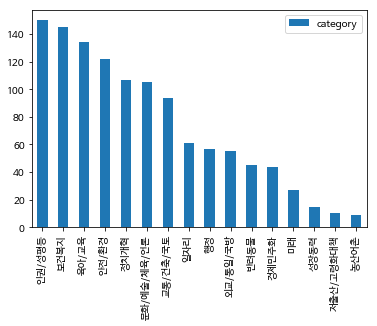

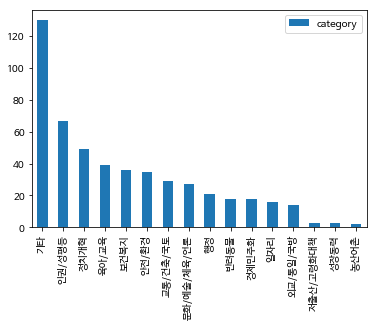

In [47]:
df_train_category_value.plot(kind='bar')
df_test_category_value.plot(kind='bar')

# 단어 벡터화 하기

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

stops = ['and', 'article', 'html', '수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = stops, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(1, 3), preprocessor=None,
        stop_words=['and', 'article', 'html', '수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜', '같은', '같습니다', '없습니다', '위해', '한다'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [49]:
%%time 
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessing2'])
train_feature_vector.shape

CPU times: user 3.14 s, sys: 58.2 ms, total: 3.2 s
Wall time: 3.21 s


In [50]:
%%time 
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessing2'])
test_feature_vector.shape

CPU times: user 1.35 s, sys: 25.8 ms, total: 1.37 s
Wall time: 1.38 s


In [51]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['aid',
 'all',
 'articleview',
 'articleview idxno',
 'as',
 'asp',
 'aspx',
 'aspx cntn',
 'aspx cntn cd',
 'at']

In [52]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist, columns=vocab)

,aid,all,articleview,articleview idxno,as,asp,aspx,aspx cntn,aspx cntn cd,at,...,효과를,후에,훨씬,희망을,힘든,힘들게,힘들어,힘없는,힘을,힘이
0,40,45,45,19,97,91,48,159,36,35,...,43,28,70,38,21,20,22,19,49,28


In [53]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [54]:
%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

CPU times: user 4.68 ms, sys: 2.23 ms, total: 6.9 ms
Wall time: 4.68 ms


In [55]:
%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

CPU times: user 3.55 ms, sys: 2.03 ms, total: 5.58 ms
Wall time: 3.7 ms


In [56]:
test_feature_tfidf.shape

(507, 2000)

In [57]:
from collections import Counter
dict(Counter(vocab).most_common(30))

{'aid': 1,
 'all': 1,
 'articleview': 1,
 'articleview idxno': 1,
 'as': 1,
 'asp': 1,
 'aspx': 1,
 'aspx cntn': 1,
 'aspx cntn cd': 1,
 'at': 1,
 'at pg': 1,
 'at pg aspx': 1,
 'cd': 1,
 'cntn': 1,
 'cntn cd': 1,
 'co': 1,
 'co kr': 1,
 'co kr news': 1,
 'com': 1,
 'com main': 1,
 'com main read': 1,
 'com news': 1,
 'com nws': 1,
 'com nws web': 1,
 'com view': 1,
 'daum': 1,
 'daum net': 1,
 'do': 1,
 'http': 1,
 'http media': 1}

## 예측한 카테고리를 label로 사용하기

In [58]:
# 학습에 사용할 y_label 을 넣어줍니다. 기타를 제거한 카테고리 데이터를 사용합니다.
y_label = df_train['category_pred']

# 랜덤 포레스트로 학습시키기
* 공식문서 : http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [59]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [60]:
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
%time forest = forest.fit(train_feature_tfidf, y_label)

CPU times: user 1.45 s, sys: 37.3 ms, total: 1.48 s
Wall time: 620 ms


## XGBoost로 학습시키기

In [61]:
import xgboost as xgb

# XGBoost Parameters http://xgboost.readthedocs.io/en/latest/parameter.html
xgb = xgb.XGBClassifier(n_estimators=10,
                          max_depth=6,
                          learning_rate=1.0,
                          max_delta_step=1,
                          eta = 1,
                          nthread=-1,
                          seed=2018)
xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1, gamma=0, learning_rate=1.0,
       max_delta_step=1, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=10, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=2018, silent=True, subsample=1)

In [62]:
%time xgb.fit(train_feature_tfidf, y_label)

CPU times: user 4.53 s, sys: 194 ms, total: 4.73 s
Wall time: 1.42 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1, gamma=0, learning_rate=1.0,
       max_delta_step=1, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=10, n_jobs=1, nthread=-1, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=2018, silent=True, subsample=1)

# 학습이 잘 되었는지 평가하기

시험공부에 비유해 보면, (feat.애란쌤)
1. 기출문제를 모은다
2. 공부한다
3. 시험본다

여기에서 2번 단계를 하는 여러 전략이 있을텐데요, 기출문제를 모두 외워버리면 과연 내가 실제 시험을 잘 치룰 수 있을지 아니면 공부를 더 해야할지 판단하기가 애매합니다. 괜찮은 전략 중 하나는 기출문제 중 일부를 임의로 뽑아내서 공부하고(training set을 이용한 학습), 나머지 기출문제를 풀어보며 내가 얼마나 잘 푸는지 평가를 해보는겁니다(validation set을 통해 학습의 성과를 검증). 잘 된다 싶으면 시험을 볼 준비가 된 것입니다(실전 투입).


기출문제를 몽땅 외우면 기출문제 내에서는 100점을 받겠지만(overfitting), 실전에서도 그러한 성적을 가두리라 기대하기 어렵습니다.

## RF 평가

In [63]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score = cross_val_score(forest, train_feature_vector, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

CPU times: user 116 ms, sys: 48.2 ms, total: 164 ms
Wall time: 2 s


array([0.39830508, 0.46610169, 0.38983051, 0.39830508, 0.47033898])

In [64]:
round(np.mean(score)*100,2)

42.46

## xgb 평가

In [65]:
%time score_xgb = cross_val_score(xgb, train_feature_tfidf, y_label, scoring="accuracy").mean()
print(round(np.mean(score_xgb)*100,2))

/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


CPU times: user 8.27 s, sys: 574 ms, total: 8.85 s
Wall time: 3 s
33.49


/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# 예측
## RF

In [66]:
# 테스트 데이터를 넣고 예측합니다.
y_pred = forest.predict(test_feature_vector)
y_pred[:3]

array(['교통/건축/국토', '반려동물', '인권/성평등'], dtype=object)

In [67]:
y_pred.shape

(507,)

## XGB

In [68]:
y_pred_xgb = xgb.predict(test_feature_tfidf)

/Users/corazzon/codes/jupyter/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [69]:
print(y_pred_xgb.shape)
df_test['category_pred_xgb'] = y_pred_xgb
y_pred_xgb[:5]

(507,)


array(['인권/성평등', '인권/성평등', '인권/성평등', '인권/성평등', '육아/교육'], dtype=object)

In [70]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output = pd.DataFrame(data={'category_pred':y_pred})
output.head()

,category_pred
0,교통/건축/국토
1,반려동물
2,인권/성평등
3,인권/성평등
4,육아/교육


### RF로 예측한 카테고리

In [71]:
# 0과 1이 어떻게 집계 되었는지 확인합니다.
# 실제 데이터에는 답변 대상 건이 있는데 없는 것으로 예측되었
output['category_pred'].value_counts()

안전/환경          122
육아/교육           92
인권/성평등          76
보건복지            75
반려동물            59
문화/예술/체육/언론     28
교통/건축/국토        20
정치개혁            16
외교/통일/국방         9
경제민주화            5
일자리              3
미래               2
Name: category_pred, dtype: int64

### XGB로 예측한 카테고리

In [72]:
df_test['category_pred_xgb'].value_counts()

인권/성평등         148
안전/환경           82
육아/교육           59
보건복지            56
문화/예술/체육/언론     36
교통/건축/국토        35
반려동물            30
정치개혁            30
행정              13
일자리              9
경제민주화            7
미래               2
Name: category_pred_xgb, dtype: int64

In [73]:
df_test['category_pred'] = y_pred

In [74]:
df_test['pred_diff'] = 0
df_test['pred_diff'] = (df_test['category'] == df_test['category_pred'] ) == 1
df_test['pred_diff'] = df_test['pred_diff'].astype(int)
df_test.head(3)

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,category_pred_xgb,pred_diff
156027,190000,2018-04-08,2018-05-08,0,2099,문화/예술/체육/언론,전명규 교수 구속수사와 빙상연맹비리 압수수사 를 원합니다.,전명규 한체대교수와 빙상연맹의 전명규 감싸기를 철저히조사해 일벌백계 해주시시를 바랍...,교통/건축/국토,전명규 한체대교수와 빙상연맹의 전명규 감싸기를 철저히조사해 일벌백계 해주시시를 바랍...,전명규 한체대교수와 빙상연맹의 전명규 감싸기를 철저히조사해 일벌백계 해주시시를 바랍...,인권/성평등,0
156928,191527,2018-04-08,2018-05-08,0,13683,경제민주화,정부는 금융적폐청산에 내일 당장 나서 주세요,삼성증권의 112조원 위조증권 발행으로 대한민국 증권시장은 이미 죽었습니다.\n일개...,반려동물,삼성증권의 조원 위조증권 발행으로 대한민국 증권시장은 이미 죽었습니다 일개 ...,삼성증권의 조원 위조증권 발행으로 대한민국 증권시장은 이미 죽었습니다 일개 ...,인권/성평등,0
157043,191715,2018-04-09,2018-05-09,0,4053,보건복지,성인 아토피 치료제 '듀피젠트'의 빠른 보험화에 관한 건.,현대인의 고질병으로 불리우는 아토피 피부염이라는 질병 들어보셨을 겁니다.\n최근의 ...,인권/성평등,현대인의 고질병으로 불리우는 아토피 피부염이라는 질병 들어보셨을 겁니다 최근의 국...,현대인의 고질병으로 불리우는 아토피 피부염이라는 질병 들어보셨을 겁니다 최근의 국...,인권/성평등,0


In [75]:
df_test['pred_diff_xgb'] = 0
df_test['pred_diff_xgb'] = (df_test['category'] == df_test['category_pred_xgb'] ) == 1
df_test['pred_diff_xgb'] = df_test['pred_diff_xgb'].astype(int)
df_test.head(3)

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,category_pred_xgb,pred_diff,pred_diff_xgb
156027,190000,2018-04-08,2018-05-08,0,2099,문화/예술/체육/언론,전명규 교수 구속수사와 빙상연맹비리 압수수사 를 원합니다.,전명규 한체대교수와 빙상연맹의 전명규 감싸기를 철저히조사해 일벌백계 해주시시를 바랍...,교통/건축/국토,전명규 한체대교수와 빙상연맹의 전명규 감싸기를 철저히조사해 일벌백계 해주시시를 바랍...,전명규 한체대교수와 빙상연맹의 전명규 감싸기를 철저히조사해 일벌백계 해주시시를 바랍...,인권/성평등,0,0
156928,191527,2018-04-08,2018-05-08,0,13683,경제민주화,정부는 금융적폐청산에 내일 당장 나서 주세요,삼성증권의 112조원 위조증권 발행으로 대한민국 증권시장은 이미 죽었습니다.\n일개...,반려동물,삼성증권의 조원 위조증권 발행으로 대한민국 증권시장은 이미 죽었습니다 일개 ...,삼성증권의 조원 위조증권 발행으로 대한민국 증권시장은 이미 죽었습니다 일개 ...,인권/성평등,0,0
157043,191715,2018-04-09,2018-05-09,0,4053,보건복지,성인 아토피 치료제 '듀피젠트'의 빠른 보험화에 관한 건.,현대인의 고질병으로 불리우는 아토피 피부염이라는 질병 들어보셨을 겁니다.\n최근의 ...,인권/성평등,현대인의 고질병으로 불리우는 아토피 피부염이라는 질병 들어보셨을 겁니다 최근의 국...,현대인의 고질병으로 불리우는 아토피 피부염이라는 질병 들어보셨을 겁니다 최근의 국...,인권/성평등,0,0


In [76]:
# RF로 맞게 예측한 청원은 1, 틀린 예측은 0으로 표기되었습니다.
pred_diff = df_test['pred_diff'].value_counts()
pred_diff

0    467
1     40
Name: pred_diff, dtype: int64

In [77]:
# XGB로 맞게 예측한 청원은 1, 틀린 예측은 0으로 표기되었습니다.
pred_diff_xgb = df_test['pred_diff_xgb'].value_counts()
pred_diff_xgb

0    463
1     44
Name: pred_diff_xgb, dtype: int64

In [78]:
print('RF 전체 {}건의 데이터 중 {}건 예측'.format(y_pred.shape[0], pred_diff[1]))

RF 전체 507건의 데이터 중 40건 예측


In [79]:
print('XGB 전체 {}건의 데이터 중 {}건 예측'.format(y_pred_xgb.shape[0], pred_diff_xgb[1]))

XGB 전체 507건의 데이터 중 44건 예측


In [80]:
acc = ( pred_diff[1] / y_pred.shape[0] )*100 
print('예측 비율 {}'.format(acc))

예측 비율 7.889546351084813


In [81]:
acc = ( pred_diff_xgb[1] / y_pred_xgb.shape[0] )*100 
print('예측 비율 {}'.format(acc))

예측 비율 8.678500986193294


In [82]:
# 제대로 예측한 카테고리 데이터를 봅니다.
predict_correct = df_test.loc[df_test['pred_diff'] == 1]
predict_correct.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,category_pred_xgb,pred_diff,pred_diff_xgb
159216,195377,2018-04-11,2018-05-11,0,1508,보건복지,외국인영주권자 처우 및 복지혜택 개선 관련 청원 取得永住权的在韩外国人待遇 及福利改...,알고 계시나요? 대한민국의 외국인 영주권 납세자 아동 및 노인을 복지 혜택이 없는 ...,보건복지,알고 계시나요 대한민국의 외국인 영주권 납세자 아동 및 노인을 복지 혜택이 없는 ...,알고 계시나요 대한민국의 외국인 영주권 납세자 아동 노인을 복지 혜택이 사실 영...,보건복지,1,1
161163,198397,2018-04-13,2018-05-13,0,2421,육아/교육,과학탐구실험 교과의 석차 등급 폐지,과학탐구실험 교과의 석차등급을 폐지하고 성취도 평가만 실시할 수 있도록 해주세요.\...,육아/교육,과학탐구실험 교과의 석차등급을 폐지하고 성취도 평가만 실시할 수 있도록 해주세요 ...,과학탐구실험 교과의 석차등급을 폐지하고 성취도 평가만 실시할 있도록 해주세요 ...,인권/성평등,1,0
161390,198784,2018-04-14,2018-05-14,0,19905,인권/성평등,대한항공 명칭변경 및 경영관련 내부조사 요구,대한항공은 “땅콩 회항”사건 이후에도 다시금 “물컵” 논란에 휩싸였습니다. 최근 동...,인권/성평등,대한항공은 땅콩 회항 사건 이후에도 다시금 물컵 논란에 휩싸였습니다 최근 동...,대한항공은 땅콩 회항 사건 이후에도 다시금 물컵 논란에 휩싸였습니다 최근 동...,인권/성평등,1,1
161612,199190,2018-04-14,2018-05-14,0,1279,보건복지,첨단재생의료법 통과시켜주세요,치매로 인하여 수많은 사람들이 고통받고 있습니다.\n우리도 치료기술이 개발되었습니다...,보건복지,치매로 인하여 수많은 사람들이 고통받고 있습니다 우리도 치료기술이 개발되었습니다 ...,치매로 인하여 수많은 사람들이 고통받고 우리도 치료기술이 개발되었습니다 그러나 ...,보건복지,1,1
162967,201413,2018-04-16,2018-05-16,0,3667,보건복지,병원 요양병원 병상당 약사수 지정,시중약국은 환자75명 당 약사1인을 고용하도록 차별수가제를 적용후 비약사조제가 많이...,보건복지,시중약국은 환자 명 당 약사 인을 고용하도록 차별수가제를 적용후 비약사조제가 많이...,시중약국은 환자 명 당 약사 인을 고용하도록 차별수가제를 적용후 비약사조제가 많이...,문화/예술/체육/언론,1,0


In [83]:
predict_incorrect = df_test.loc[df_test['pred_diff_xgb'] == 0].copy()
predict_incorrect.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2,category_pred_xgb,pred_diff,pred_diff_xgb
156027,190000,2018-04-08,2018-05-08,0,2099,문화/예술/체육/언론,전명규 교수 구속수사와 빙상연맹비리 압수수사 를 원합니다.,전명규 한체대교수와 빙상연맹의 전명규 감싸기를 철저히조사해 일벌백계 해주시시를 바랍...,교통/건축/국토,전명규 한체대교수와 빙상연맹의 전명규 감싸기를 철저히조사해 일벌백계 해주시시를 바랍...,전명규 한체대교수와 빙상연맹의 전명규 감싸기를 철저히조사해 일벌백계 해주시시를 바랍...,인권/성평등,0,0
156928,191527,2018-04-08,2018-05-08,0,13683,경제민주화,정부는 금융적폐청산에 내일 당장 나서 주세요,삼성증권의 112조원 위조증권 발행으로 대한민국 증권시장은 이미 죽었습니다.\n일개...,반려동물,삼성증권의 조원 위조증권 발행으로 대한민국 증권시장은 이미 죽었습니다 일개 ...,삼성증권의 조원 위조증권 발행으로 대한민국 증권시장은 이미 죽었습니다 일개 ...,인권/성평등,0,0
157043,191715,2018-04-09,2018-05-09,0,4053,보건복지,성인 아토피 치료제 '듀피젠트'의 빠른 보험화에 관한 건.,현대인의 고질병으로 불리우는 아토피 피부염이라는 질병 들어보셨을 겁니다.\n최근의 ...,인권/성평등,현대인의 고질병으로 불리우는 아토피 피부염이라는 질병 들어보셨을 겁니다 최근의 국...,현대인의 고질병으로 불리우는 아토피 피부염이라는 질병 들어보셨을 겁니다 최근의 국...,인권/성평등,0,0
157508,192485,2018-04-09,2018-05-09,0,4141,성장동력,"우리는 왜 언제나 ""패스트 팔로워""일 수밖에 없는가? - 공직사회의 보신주의와 발목...","문재인 대통령이 취임한지 벌써 1년이 되어갑니다.\n많은 변화들이 있었고 특히, 한...",인권/성평등,문재인 대통령이 취임한지 벌써 년이 되어갑니다 많은 변화들이 있었고 특히 한반...,문재인 대통령이 취임한지 벌써 년이 되어갑니다 변화들이 있었고 특히 한반도 평...,인권/성평등,0,0
157543,192526,2018-04-09,2018-05-09,0,2081,안전/환경,페트병 라벨부착방식 변경으로 재활용쓰레기 대란 해소,(페트병 라벨부착방식 변경으로 재활용쓰레기 대란 해소)\n1. 우리나라 페트병 쓰레...,육아/교육,페트병 라벨부착방식 변경으로 재활용쓰레기 대란 해소 우리나라 페트병 쓰레기...,페트병 라벨부착방식 변경으로 재활용쓰레기 대란 해소 우리나라 페트병 쓰레기...,육아/교육,0,0


In [84]:
predict_incorrect_value = predict_incorrect['category'].value_counts()
predict_incorrect_value

기타             130
인권/성평등          49
정치개혁            46
육아/교육           35
보건복지            30
안전/환경           30
교통/건축/국토        28
문화/예술/체육/언론     23
행정              19
경제민주화           18
반려동물            17
일자리             16
외교/통일/국방        14
저출산/고령화대책        3
성장동력             3
농산어촌             2
Name: category, dtype: int64

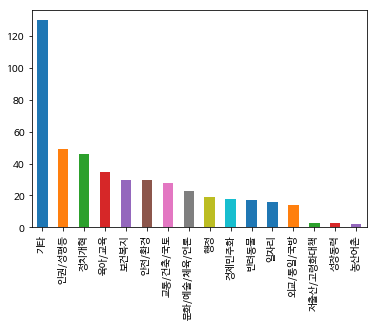

In [85]:
# 잘못 예측한 카테고리 중 인권/성평등 카테고리가 가장 많습니다.
predict_incorrect_value.plot(kind='bar')

# 왜 예측의 정확도가 낮을까요?
* 청원을 입력하는 사람마다 카테고리 분류 기준이 정확하지 않은 것 같습니다.
* 기타로 예측한 분류도 특정 카테고리로 분류해도 될 것으로 보여집니다.

In [86]:
predict_incorrect[['category', 'category_pred', 'title', 'content']].head(10)

,category,category_pred,title,content
156027,문화/예술/체육/언론,교통/건축/국토,전명규 교수 구속수사와 빙상연맹비리 압수수사 를 원합니다.,전명규 한체대교수와 빙상연맹의 전명규 감싸기를 철저히조사해 일벌백계 해주시시를 바랍...
156928,경제민주화,반려동물,정부는 금융적폐청산에 내일 당장 나서 주세요,삼성증권의 112조원 위조증권 발행으로 대한민국 증권시장은 이미 죽었습니다.\n일개...
157043,보건복지,인권/성평등,성인 아토피 치료제 '듀피젠트'의 빠른 보험화에 관한 건.,현대인의 고질병으로 불리우는 아토피 피부염이라는 질병 들어보셨을 겁니다.\n최근의 ...
157508,성장동력,인권/성평등,"우리는 왜 언제나 ""패스트 팔로워""일 수밖에 없는가? - 공직사회의 보신주의와 발목...","문재인 대통령이 취임한지 벌써 1년이 되어갑니다.\n많은 변화들이 있었고 특히, 한..."
157543,안전/환경,육아/교육,페트병 라벨부착방식 변경으로 재활용쓰레기 대란 해소,(페트병 라벨부착방식 변경으로 재활용쓰레기 대란 해소)\n1. 우리나라 페트병 쓰레...
157763,문화/예술/체육/언론,안전/환경,tv 조선의 csi 소비자 탐사대 19회 미용실편의 악의적 보도에 대한 정정방송을 ...,2018년 4월 8일 TV조선에 방송된 미용실에서 머리 하기 전 뿌리는 물의 충격...
157777,일자리,반려동물,SKBroadband 매니져의 비윤리적인 행태 와 갑질,대구 품질솔루션에있는 운용매니져에대한 비윤리적인 갑질을 고발할려고합니다\nSK브로드...
157813,보건복지,반려동물,식약처는 김미영씨 의약기기 수입에대해 검찰에 기소한것을 취소하라,kbs2 에 나온 방송을 보았습니다. 유아당뇨 환자를 위해 실시간 당뇨측정기를 수입...
157976,반려동물,육아/교육,도와주세요. 저희 개가 이웃에게 처참히 죽임을 당했습니다.,3월4일 일요일 오후5시44분이 자택에 설치되어있던 CCTV속의 모습이 마지막이 되...
158094,경제민주화,인권/성평등,김기식 금감원장님을 무슨일이 있어도 지켜주세요!!,최근에 터진 삼성증권 사태 및 금융적폐를 뿌리뽑을 수 있는 유일한 분입니다.\n하지...


## 원래 데이터 중 기타로 분류되었으나 분류기가 다르게 예측한 청원을 봅니다.

In [87]:
predict_incorrect_etc = predict_incorrect.loc[predict_incorrect['category'] == '기타'].copy()
predict_incorrect_etc[['category', 'category_pred', 'title', 'content']].head(10)

,category,category_pred,title,content
345,기타,보건복지,문재인 대통령 기념 시계도 판매하라.,문재인 대통령 싸인이 들어간 기념 시계를 판매용으로 전환하여 주세요. SNS상의 국...
487,기타,인권/성평등,2017년 10월 원천세 신고기한 및 9월분 전자세금계산서 발행기한일을 10월 13...,2017년 추석연휴 및 10월 2일 임시공휴일 지정이 확정됨에 따라 10월 초에 법...
12747,기타,안전/환경,억울한죽음으로 돌아가신 고 이길연집배원의 순직을요구합니다,9월5일 서광주우체국에 근속중이신 고 이길연집배원 저희아버지가 자택에서 홀로목숨을끈...
15456,기타,보건복지,화훼도매시장 출입에 대한 출입증 발급을 청원합니다,화훼쪽에 종사하고 있는 사람입니다\n김영란법이 터지고 나서 뉴스를 보면 양재화훼시장...
17150,기타,인권/성평등,TNS홀딩스 강태욱 대표 사기 횡령 사건 해결을 부탁드립니다.,안녕하세요\n영등포구에 거주하는 30살 직장인입니다.\n2014년부터 알고지낸 재무...
19072,기타,안전/환경,'일간베스트'사이트를 폐지해주세요,"국민들을 불편하게하고, 주변에 민폐를 끼치기로 유명한 일베는 사회적이슈로도 자주 떠..."
22162,기타,문화/예술/체육/언론,경찰들의 성교육 이수 및 가중처벌,최근 경찰의 성폭행 성추행 성희롱등 그 주체가 범죄를 다루고 있는 경찰이된 사건들이...
22375,기타,안전/환경,튜닝카 법 개정,차량튜닝에대한 법 개정이 필요할것같습니다. 요즘 튜닝사업이 확대되는 시대 입니다. ...
22551,기타,교통/건축/국토,을지대학교병원지부 노동조합 파업사태 해결 촉구,"문재인 대통령께\n안녕하세요 대통령님, 저는 대전 을지대학교병원에 근무하는 병원노동..."
23292,기타,보건복지,우리나라 법은 도대체 누구를 위한 법입니까 법 개선과 피해자를 위한 제도마련이 필요...,안녕하세요 .\n오늘도 국민들을 위해 나라에 힘써주시느라 너무나 고생이 많으십니다....


In [88]:
acc = ( pred_diff[1] / y_pred.shape[0] )*100 
print('예측 비율 {}'.format(acc))

예측 비율 7.889546351084813


In [89]:
acc = ( pred_diff_xgb[1] / y_pred_xgb.shape[0] )*100 
print('예측 비율 {}'.format(acc))

예측 비율 8.678500986193294
